# 客户营销响应评分卡（与申请信用评分卡技术路线一致）

### 注：本分享视频使用网上公开获取的“2015年汇丰杯SAS大赛决赛试题”进行演示
###        获取网址如下：https://bbs.pinggu.org/a-2555795.html
###        录制本视频的目的是分享评分卡制作技术，用于非盈利目的
###        本视频由常国珍制作，如有侵权，请联系本人协助处理
###        参与和讨论本示例代码编写者有赵仁乾、曾珂、钱小菲，同时感谢scorecardpy 包的贡献者谢士晨先生

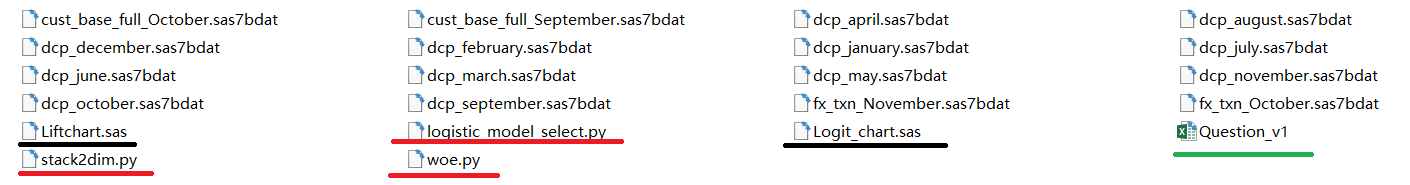

## 一、几个重要概念：

### 1、制作评分卡的总体流程
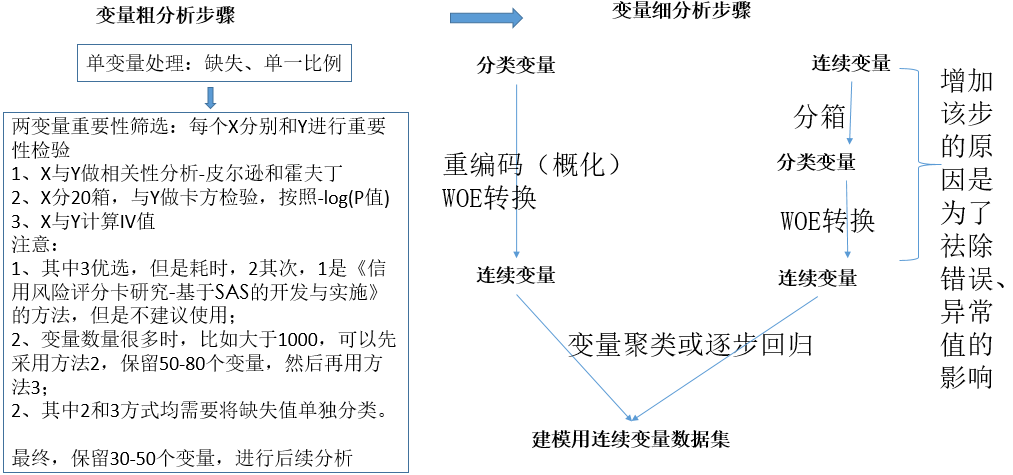

###############################################################################################################################

### 2、连续变量分箱，分类变量概化处理

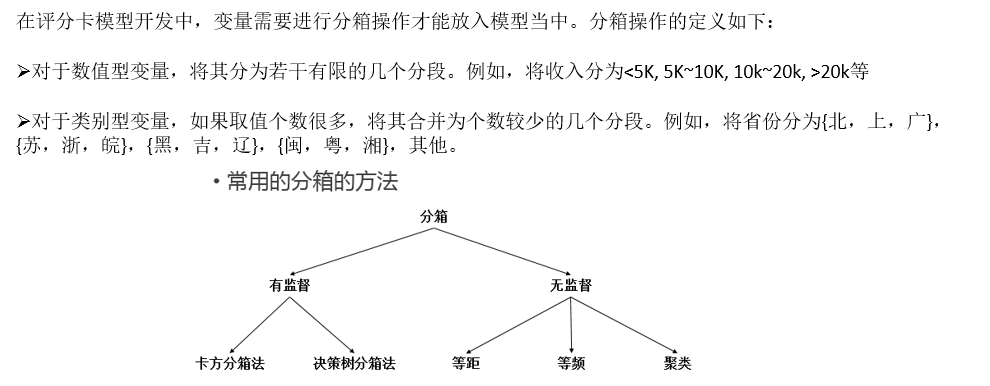

###  概化的原则：1）概化后每组的样本量不能太少，比如样本量占比小于5%的组需要再次合并；2）合并后每组中Y=1的占比应该接近；3）一般评分卡入模变量保留2-5组即可，分组不需要太多

- 概化处理的原因-似不完整数据问题

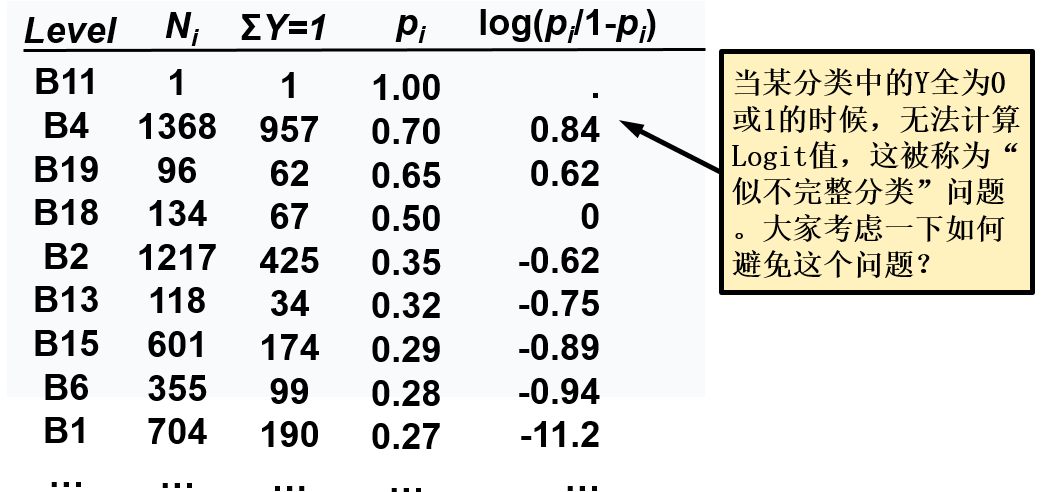

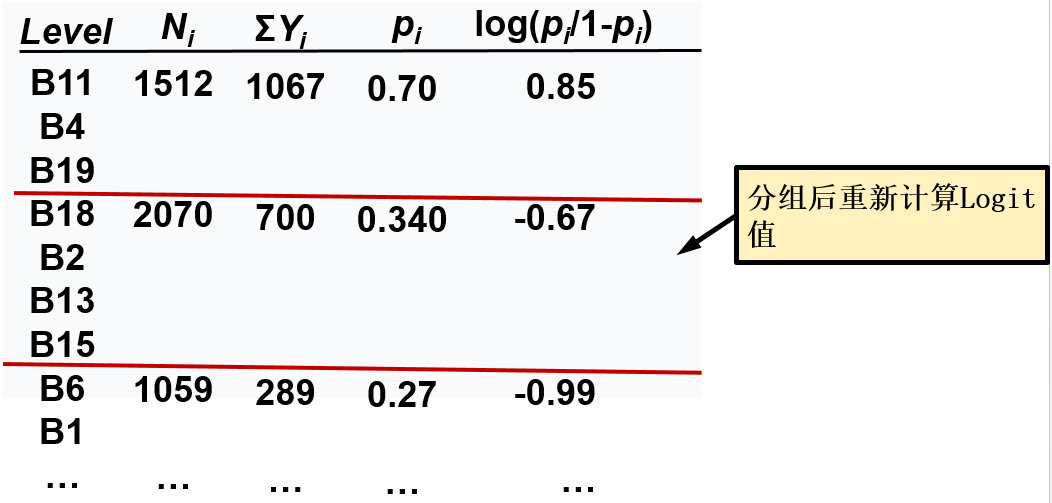

###############################################################################################################################

### 3、WoE与IV
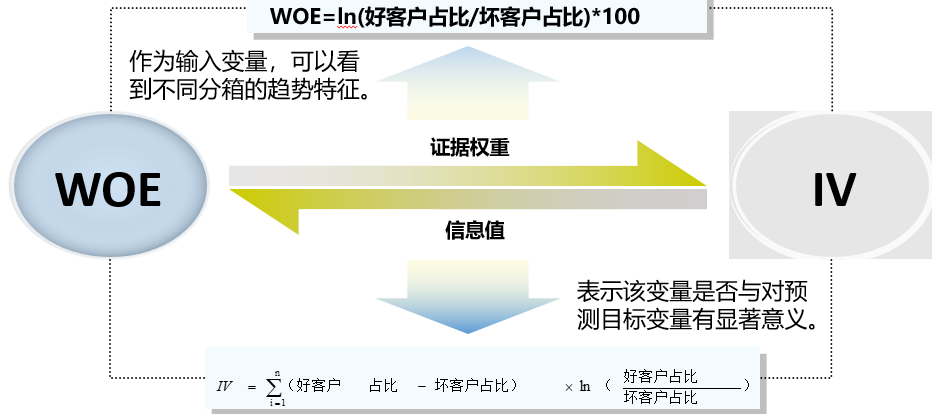


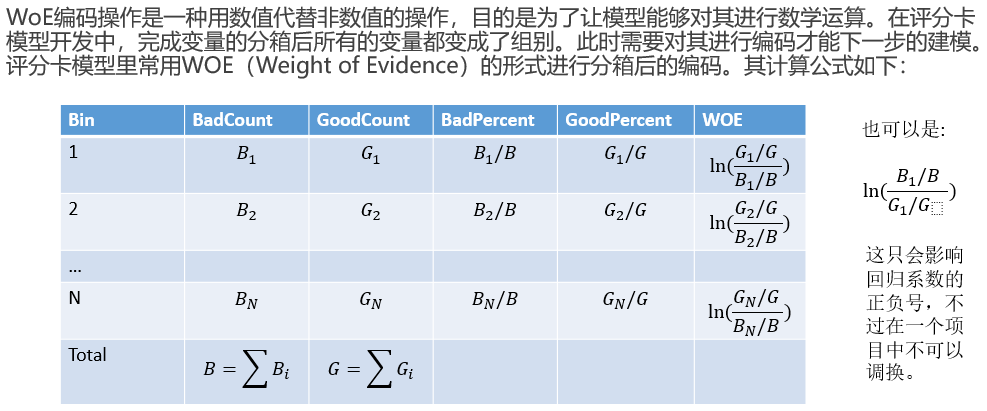

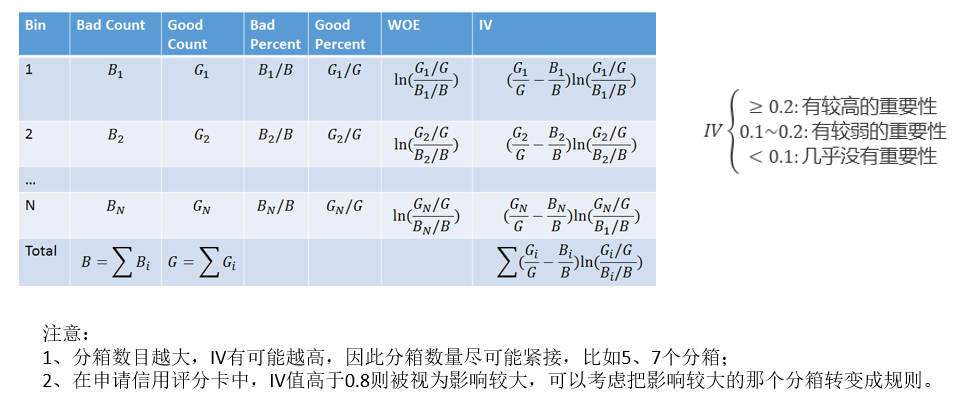

###############################################################################################################################

# 二、问题回答

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline

In [2]:
os.chdir(r'Data')
os.getcwd()

'C:\\Users\\THINKPAD\\Desktop\\Scorecard_SASCom2015\\Data'

# Q1

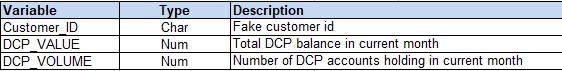

用DCP产品表为客户总表增加分析维度，创建变量。

In [3]:
cust_base_full_October = pd.read_sas(r'cust_base_full_October.sas7bdat')
cust_base_full_September = pd.read_sas(r'cust_base_full_September.sas7bdat')

In [4]:
cust_base_full_September.head()

,Customer_ID,Age,Education_level,Gender_code,Internet_bank_user,Marital_status,Occupation,Residential_status,Cust_RELATIONSHIP,Cust_RELATIONSHIP_L3,...,txn_sav_ATM_cnt,txn_sav_ATM_amt,txn_sav_Others_cnt,txn_sav_Others_amt,txn_sav_Deposit_cnt,txn_sav_Deposit_amt,txn_sav_Withdrawal_cnt,txn_sav_Withdrawal_amt,txn_BondCD_cnt,txn_BondCD_amt
0,b'000001',57.0,b'S',b'F',b'Y',b'S',b'15. Clericals',b'S',56716.38,9.128666e+04,...,7.0,57400.01,1.0,57751.68,11.0,57751.72,1.0,57399.99,NaN,NaN
1,b'000002',62.0,b'S',b'M',b'N',b'M',b'13. Sales',NaN,401564.16,3.868797e+05,...,8.0,29700.00,6.0,914.19,8.0,36141.15,8.0,30536.96,NaN,NaN
2,b'000003',60.0,NaN,b'M',b'Y',NaN,b'22. Retired',NaN,2326386.18,2.079993e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,b'000004',45.0,b'U',b'M',b'Y',b'S',b'No Information',NaN,609426.51,6.022941e+05,...,1.0,138.99,1.0,0.02,1.0,0.02,1.0,138.99,NaN,NaN
4,b'000005',58.0,b'M',b'M',b'N',b'M',b'01. Managerial/Executives',NaN,1435797.13,1.424191e+06,...,NaN,NaN,5.0,98525.11,3.0,137000.22,3.0,98524.90,NaN,NaN


## Q1(a)  


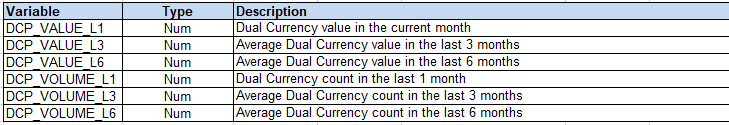

- 以下是取数窗口的设置的一个示例

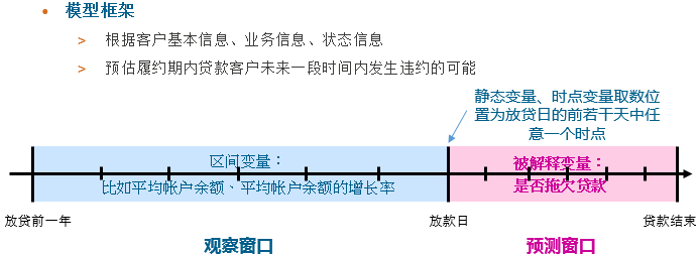

将Dual currency product 1-12月分表汇总一个总表：

In [5]:
dcpfile = os.listdir()
createVar = locals()
table_list = []
n = 0
for i in dcpfile:
    if i.startswith("dcp_"):        
        createVar[i.split('.')[0]] = pd.read_sas(i) 
        if n == 0:
            total_table = createVar[i.split('.')[0]]
        else:
            total_table = pd.merge(total_table, createVar[i.split('.')[0]], on = 'customer_id', how = 'outer')
        n += 1

In [6]:
total_table.head()

,customer_id,dcp_volume_april,dcp_value_april,dcp_volume_august,dcp_value_august,dcp_volume_december,dcp_value_december,dcp_volume_february,dcp_value_february,dcp_volume_january,...,dcp_volume_march,dcp_value_march,dcp_volume_may,dcp_value_may,dcp_volume_november,dcp_value_november,dcp_volume_october,dcp_value_october,dcp_volume_september,dcp_value_september
0,b'000164',1.0,407581.40,NaN,NaN,NaN,NaN,1.0,402557.0,1.0,...,1.0,401082.19,1.0,404460.23,NaN,NaN,NaN,NaN,NaN,NaN
1,b'000234',1.0,5345381.28,NaN,NaN,NaN,NaN,1.0,10472422.5,NaN,...,NaN,NaN,1.0,5469797.92,NaN,NaN,1.0,5073819.82,1.0,5296690.75
2,b'000412',1.0,286532.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,280000.00,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1268523.20
3,b'001383',2.0,135755.12,NaN,NaN,NaN,NaN,2.0,135660.0,NaN,...,1.0,65331.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,b'001983',1.0,135000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Q1(b)

通过上面DCP 1-12月汇总表为9月、10月增加如下变量：  
DCP_VALUE_L1  
DCP_VALUE_L3  
DCP_VALUE_L6  
DCP_VOLUME_L1  
DCP_VOLUME_L3  
DCP_VOLUME_L6

并将变量加入到9月、10月主表中。

#### [CUST_BASE_FULL_w_DCP_September]

In [7]:
total_table_sep = total_table
dict_sep = {'L1':['september'], 'L3':['june','august','september'], 
         'L6':['april','may','june','july','august','september']}
for key,value in dict_sep.items():
    for item in ['value_', 'volume_']:
        new_column = 'DCP_' + item.upper() + key
        index_column = ['dcp_' + item + x for x in dict_sep[key]]
        total_table_sep[new_column] = total_table_sep[index_column].apply('mean', axis = 1)   

In [8]:
total_table_sep.head()

,customer_id,dcp_volume_april,dcp_value_april,dcp_volume_august,dcp_value_august,dcp_volume_december,dcp_value_december,dcp_volume_february,dcp_value_february,dcp_volume_january,...,dcp_volume_october,dcp_value_october,dcp_volume_september,dcp_value_september,DCP_VALUE_L1,DCP_VOLUME_L1,DCP_VALUE_L3,DCP_VOLUME_L3,DCP_VALUE_L6,DCP_VOLUME_L6
0,b'000164',1.0,407581.40,NaN,NaN,NaN,NaN,1.0,402557.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.060208e+05,1.00
1,b'000234',1.0,5345381.28,NaN,NaN,NaN,NaN,1.0,10472422.5,NaN,...,1.0,5073819.82,1.0,5296690.75,5296690.75,1.0,7973910.74,1.5,6.690750e+06,1.25
2,b'000412',1.0,286532.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,1268523.20,1268523.20,1.0,1268523.20,1.0,7.575458e+05,1.00
3,b'001383',2.0,135755.12,NaN,NaN,NaN,NaN,2.0,135660.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.357551e+05,2.00
4,b'001983',1.0,135000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.350000e+05,1.00


In [9]:
column_to_add = ['customer_id']
column_to_add.extend([name for name in total_table_sep.columns if name.startswith('DCP_')])
CUST_BASE_FULL_w_DCP_September = pd.merge(cust_base_full_September,total_table_sep[column_to_add],
                                    left_on = 'Customer_ID', right_on = 'customer_id', how = 'left')

In [10]:
CUST_BASE_FULL_w_DCP_September.head()

,Customer_ID,Age,Education_level,Gender_code,Internet_bank_user,Marital_status,Occupation,Residential_status,Cust_RELATIONSHIP,Cust_RELATIONSHIP_L3,...,txn_sav_Withdrawal_amt,txn_BondCD_cnt,txn_BondCD_amt,customer_id,DCP_VALUE_L1,DCP_VOLUME_L1,DCP_VALUE_L3,DCP_VOLUME_L3,DCP_VALUE_L6,DCP_VOLUME_L6
0,b'000001',57.0,b'S',b'F',b'Y',b'S',b'15. Clericals',b'S',56716.38,9.128666e+04,...,57399.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,b'000002',62.0,b'S',b'M',b'N',b'M',b'13. Sales',NaN,401564.16,3.868797e+05,...,30536.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,b'000003',60.0,NaN,b'M',b'Y',NaN,b'22. Retired',NaN,2326386.18,2.079993e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,b'000004',45.0,b'U',b'M',b'Y',b'S',b'No Information',NaN,609426.51,6.022941e+05,...,138.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,b'000005',58.0,b'M',b'M',b'N',b'M',b'01. Managerial/Executives',NaN,1435797.13,1.424191e+06,...,98524.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### [CUST_BASE_FULL_w_DCP_October]

In [12]:
total_table_oct = total_table
dict_oct = {'L1':['october'], 'L3':['august','september','october'], 
         'L6':['may','june','july','august','september','october']}
for key,value in dict_oct.items():
    for item in ['value_', 'volume_']:
        new_column = 'DCP_' + item.upper() + key
        index_column = ['dcp_' + item + x for x in dict_oct[key]]
        total_table_oct[new_column] = total_table_oct[index_column].apply('mean', axis = 1) 


column_to_add = ['customer_id']
column_to_add.extend([name for name in total_table_oct.columns if name.startswith('DCP_')])
CUST_BASE_FULL_w_DCP_October = pd.merge(cust_base_full_October,total_table_oct[column_to_add],
                                    left_on = 'Customer_ID', right_on = 'customer_id', how = 'left')
CUST_BASE_FULL_w_DCP_October.head()

,Customer_ID,Age,Education_level,Gender_code,Internet_bank_user,Marital_status,Occupation,Residential_status,Cust_RELATIONSHIP,Cust_RELATIONSHIP_L3,...,txn_sav_Withdrawal_amt,txn_BondCD_cnt,txn_BondCD_amt,customer_id,DCP_VALUE_L1,DCP_VOLUME_L1,DCP_VALUE_L3,DCP_VOLUME_L3,DCP_VALUE_L6,DCP_VOLUME_L6
0,b'000001',57.0,b'S',b'F',b'Y',b'S',b'15. Clericals',b'S',114479.76,1.055302e+05,...,1397.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,b'000002',62.0,b'S',b'M',b'N',b'M',b'13. Sales',NaN,376719.01,3.906975e+05,...,1376.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,b'000003',60.0,NaN,b'M',b'Y',NaN,b'22. Retired',NaN,1993206.89,1.989272e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,b'000004',45.0,b'U',b'M',b'Y',b'S',b'No Information',NaN,596724.55,6.062310e+05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,b'000005',58.0,b'M',b'M',b'N',b'M',b'01. Managerial/Executives',NaN,1482123.80,1.408081e+06,...,116873.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Q2 Master table creation


## Q2(a)

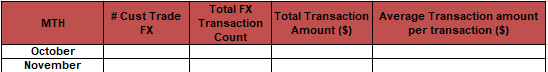

- 导入FX产品表并清洗，以FX产品表中的客户作为响应客户

In [13]:
fx_txn_November = pd.read_sas('fx_txn_November.sas7bdat')
fx_txn_October = pd.read_sas('fx_txn_October.sas7bdat')

In [14]:
fx_txn_November.head()

,Customer_ID,txn_fx_amt
0,b'000013',2543580.80
1,b'000044',1380000.00
2,b'000060',12291.36
3,b'000060',6412.68
4,b'000078',2874.46


In [15]:
CL_FX_TXN_October = fx_txn_October.txn_fx_amt.groupby(fx_txn_October.Customer_ID).agg([('txn_fx_amt_sum','sum'),('transaction_count','count')])
CL_FX_TXN_October.reset_index(inplace = True)

CL_FX_TXN_November = fx_txn_November.txn_fx_amt.groupby(fx_txn_November.Customer_ID).agg([('txn_fx_amt_sum','sum'),('transaction_count','count')])
CL_FX_TXN_November.reset_index(inplace = True)

In [16]:
CL_FX_TXN_October.head()

,Customer_ID,txn_fx_amt_sum,transaction_count
0,b'000038',574462.34,2
1,b'000076',2186359.76,1
2,b'000127',1269781.76,1
3,b'000150',130266.67,1
4,b'000160',1064000.00,1


In [17]:
CL_FX_TXN_November.head()

,Customer_ID,txn_fx_amt_sum,transaction_count
0,b'000013',2543580.80,1
1,b'000044',1380000.00,1
2,b'000060',18704.04,2
3,b'000078',2874.46,1
4,b'000082',10889479.09,1


In [18]:
October = CL_FX_TXN_October.agg({'Customer_ID':'count','transaction_count':'sum','txn_fx_amt_sum':'sum'})
November = CL_FX_TXN_November.agg({'Customer_ID':'count','transaction_count':'sum','txn_fx_amt_sum':'sum'})

roll_up_information = pd.concat([October, November],axis = 1).T
roll_up_information.columns = ['Cust Trade FX','Total FX Transaction Count','Total Transaction Amount ($)']
roll_up_information.index  = ['October','November']

roll_up_information['Average Transaction amount per transaction ($)'] = roll_up_information[['Total Transaction Amount ($)','Total FX Transaction Count']].apply(lambda x:x[0]/x[1],axis = 1)

In [24]:
roll_up_information

,Cust Trade FX,Total FX Transaction Count,Total Transaction Amount ($),Average Transaction amount per transaction ($)
October,1682.0,2661.0,2.668519e+09,1.002826e+06
November,2401.0,3874.0,2.254350e+09,5.819179e+05


## Q2(b)


#### 创建训练集和验证集
用CL_FX_TXN_November为CUST_BASE_FULL_w_DCP_October打标签，同时存在的客户为响应客户，否则为非响应客户,建表为Model_Base  
OUTTIME_Base同理

#### Model_Base

In [133]:
Model_Base = pd.merge(CUST_BASE_FULL_w_DCP_October,CL_FX_TXN_November.iloc[:,[0,2]],on = 'Customer_ID',how = 'left')

In [134]:
def response(x):
    if x > 0:
        y = 1
    else:
        y = 0
    return y
Model_Base['response'] = Model_Base['transaction_count'].map(response)

In [135]:
Model_Base.drop('transaction_count',axis = 1,inplace = True)

#### OUTTIME_Base

In [136]:
OUTTIME_Base = pd.merge(CUST_BASE_FULL_w_DCP_September,CL_FX_TXN_October.iloc[:,[0,2]],on = 'Customer_ID',how = 'left')
OUTTIME_Base['response'] = OUTTIME_Base['transaction_count'].map(response)
OUTTIME_Base.drop('transaction_count',axis = 1,inplace = True)
OUTTIME_Base.head()

,Customer_ID,Age,Education_level,Gender_code,Internet_bank_user,Marital_status,Occupation,Residential_status,Cust_RELATIONSHIP,Cust_RELATIONSHIP_L3,...,txn_BondCD_cnt,txn_BondCD_amt,customer_id,DCP_VALUE_L1,DCP_VOLUME_L1,DCP_VALUE_L3,DCP_VOLUME_L3,DCP_VALUE_L6,DCP_VOLUME_L6,response
0,b'000001',57.0,b'S',b'F',b'Y',b'S',b'15. Clericals',b'S',56716.38,9.128666e+04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,b'000002',62.0,b'S',b'M',b'N',b'M',b'13. Sales',NaN,401564.16,3.868797e+05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,b'000003',60.0,NaN,b'M',b'Y',NaN,b'22. Retired',NaN,2326386.18,2.079993e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,b'000004',45.0,b'U',b'M',b'Y',b'S',b'No Information',NaN,609426.51,6.022941e+05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,b'000005',58.0,b'M',b'M',b'N',b'M',b'01. Managerial/Executives',NaN,1435797.13,1.424191e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


# Q3


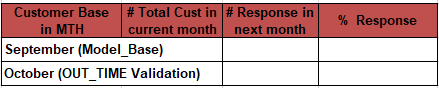

查看通过训练集Model_Base，和验证集OUTTIME_base响应比例

In [137]:
september = Model_Base.agg({'Customer_ID':'count','response':'sum'})
october = OUTTIME_Base.agg({'Customer_ID':'count','response':'sum'})

cust_resp = pd.concat([september, october],axis = 1).T
cust_resp.columns = ['Total Cust in current month','Response in next month']
cust_resp.index  = ['September','October']

cust_resp['% Response'] = cust_resp.apply(lambda x: x[1]/x[0],axis = 1)
cust_resp.index = ['September(Model_Base)','October(OUT_TIME Validation)']
cust_resp

,Total Cust in current month,Response in next month,% Response
September(Model_Base),50000,2401,0.04802
October(OUT_TIME Validation),50000,1682,0.03364


# Q4 Varible Reduction

## Q4(a)-Please do Data Cleansing step on the Model base. Please remove those variables with missing rate greater than 98%. 
分析缺失值，删除缺失比例过大的变量
- 注意：
- 1、本模型的变量大部分为业务变量，可以使用0填补缺失值。因此，题目中此处删除缺失值占比超过98%的变量，本意不是说可以容忍缺失值高达98%的变量，而是可以容忍单一值占比小于98%的变量；
- 2、之所以不做缺失值填补，是因为评分卡模型中的分箱和WoE转换步骤可以将缺失值单独作为一个分箱，无需进行填补。相对于缺失值填补，分箱操作更便捷、稳定且不易出错

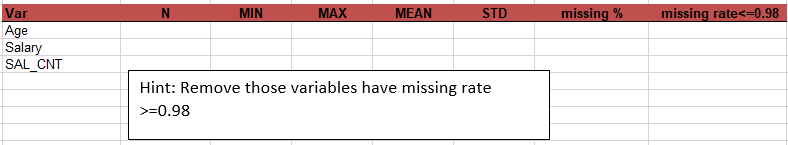

In [138]:
desc = Model_Base.describe().T

desc['missing rate'] = desc['count'].map(lambda x: (len(Model_Base) - x)/len(Model_Base))
desc['missing rate <= 0.98'] = desc['missing rate'].map(lambda x: 1 if x <= 0.98 else 0) 
desc.sort_values('missing rate <= 0.98').head()

,count,mean,std,min,25%,50%,75%,max,missing rate,missing rate <= 0.98
CUR_FCY_CNT_pct,79.0,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.99842,0
txn_cur_FCY_amt,9.0,114706.182222,322554.823280,27.790000,1419.180000,3747.74,7000.01,974260.000000,0.99982,0
TMD_LCY_CNT_pct,414.0,-0.728619,14.529921,-66.666667,0.000000,0.00,0.00,133.333333,0.99172,0
CUR_FCY_AMT_pct_all,85.0,0.814170,0.345943,0.000044,0.769052,1.00,1.00,1.000000,0.99830,0
TMD_LCY_CNT_L6,545.0,1.153211,0.598125,1.000000,1.000000,1.00,1.00,8.333333,0.98910,0


In [139]:
droplist = list(desc[desc['missing rate <= 0.98'] == 0].index)

Model_Base.drop(droplist,axis = 1,inplace = True)
Model_Base.head()

,Customer_ID,Age,Education_level,Gender_code,Internet_bank_user,Marital_status,Occupation,Residential_status,Cust_RELATIONSHIP,Cust_RELATIONSHIP_L3,...,txn_sav_ATM_cnt,txn_sav_ATM_amt,txn_sav_Others_cnt,txn_sav_Others_amt,txn_sav_Deposit_cnt,txn_sav_Deposit_amt,txn_sav_Withdrawal_cnt,txn_sav_Withdrawal_amt,customer_id,response
0,b'000001',57.0,b'S',b'F',b'Y',b'S',b'15. Clericals',b'S',114479.76,1.055302e+05,...,15.0,1677.23,1.0,0.01,19.0,280.07,2.0,1397.19,NaN,0
1,b'000002',62.0,b'S',b'M',b'N',b'M',b'13. Sales',NaN,376719.01,3.906975e+05,...,NaN,NaN,5.0,6673.27,2.0,5296.29,3.0,1376.98,NaN,0
2,b'000003',60.0,NaN,b'M',b'Y',NaN,b'22. Retired',NaN,1993206.89,1.989272e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,b'000004',45.0,b'U',b'M',b'Y',b'S',b'No Information',NaN,596724.55,6.062310e+05,...,NaN,NaN,2.0,2612.99,2.0,2612.99,NaN,NaN,NaN,0
4,b'000005',58.0,b'M',b'M',b'N',b'M',b'01. Managerial/Executives',NaN,1482123.80,1.408081e+06,...,NaN,NaN,15.0,155055.34,7.0,175181.73,10.0,116873.63,NaN,0


## Q4(b)
分析名义变量，考察其中最重要的水平，进行概化处理

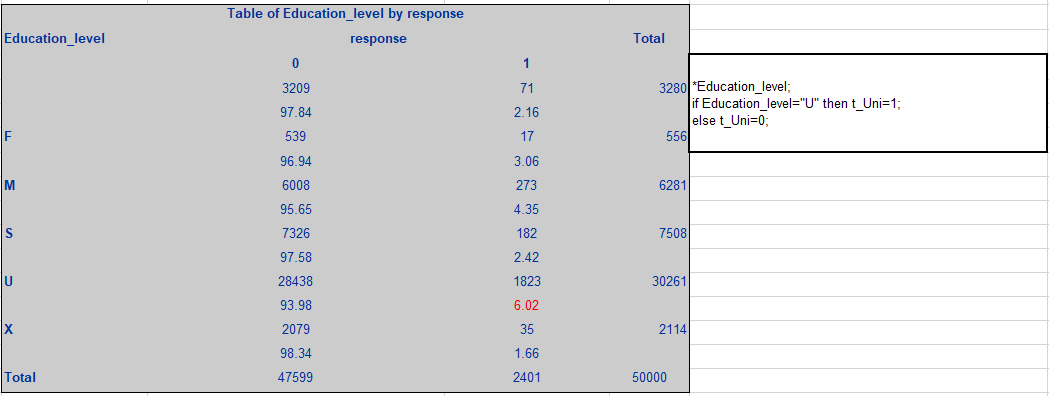

In [140]:
for col in Model_Base.columns:
    if Model_Base[col].dtype == 'O':
        if col.lower().startswith('cust'):
            continue
        else:
            #print(col)
            #print(Model_Base[col].unique(), len(Model_Base[col].unique()))
            table_resp = pd.crosstab(Model_Base[col],Model_Base.response)
            print(col,":")
            print(table_resp.div(table_resp.sum(1),axis = 0))
            print("******************************************")
            print(table_resp)
            print("####################################################################################")

Education_level :
response                0         1
Education_level                    
b'F'             0.969424  0.030576
b'M'             0.956536  0.043464
b'S'             0.975759  0.024241
b'U'             0.939757  0.060243
b'X'             0.983444  0.016556
******************************************
response             0     1
Education_level             
b'F'               539    17
b'M'              6008   273
b'S'              7326   182
b'U'             28438  1823
b'X'              2079    35
####################################################################################
Gender_code :
response            0         1
Gender_code                    
b'F'         0.963287  0.036713
b'M'         0.943791  0.056209
******************************************
response         0     1
Gender_code             
b'F'         20230   771
b'M'         27369  1630
####################################################################################
Internet_bank_user :
response

- 以上结果通过观察标准化的堆叠柱形图会更直观

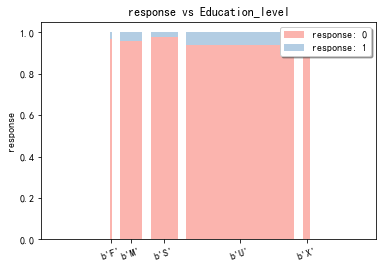

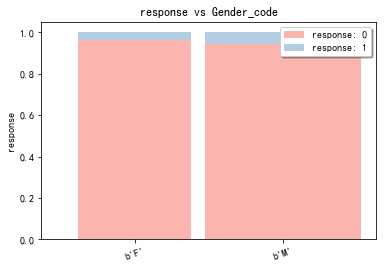

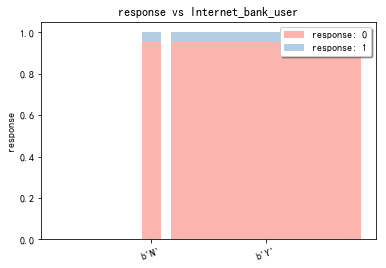

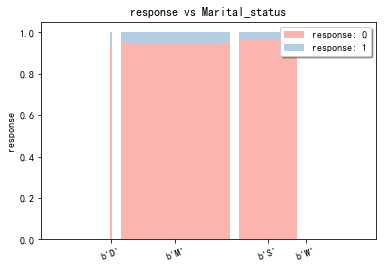

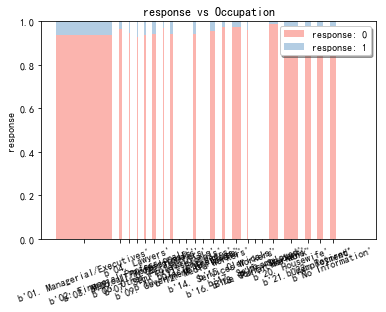

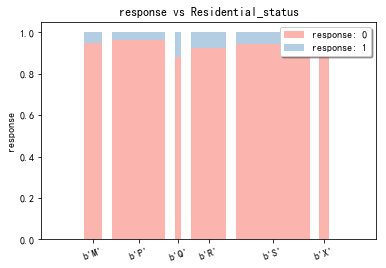

In [141]:
from stack2dim import stack2dim

for col in Model_Base.columns[1:]:
    if Model_Base[col].dtype == 'O':
        if col.lower().startswith('cust'):
            continue
        else:
            stack2dim(Model_Base,col,'response',rotation = 20)


- 也可以观看Logit曲线

C:\Users\THINKPAD\Desktop\Scorecard_SASCom2015\Data\woe.py:150: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  stat = self.df.groupby("labels")['Y'].agg({'mean': np.mean, 'bad': np.count_nonzero, 'obs': np.size}).copy()
C:\Users\THINKPAD\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Education_level


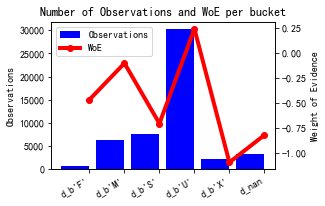

Gender_code


C:\Users\THINKPAD\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


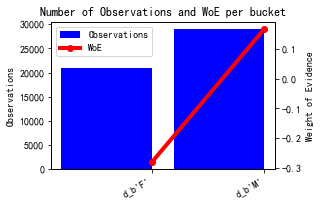

Internet_bank_user


C:\Users\THINKPAD\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


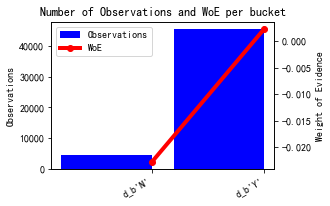

Marital_status


C:\Users\THINKPAD\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


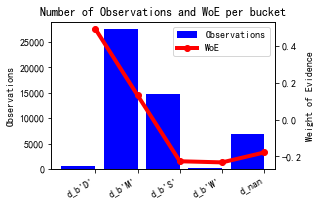

Occupation


C:\Users\THINKPAD\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


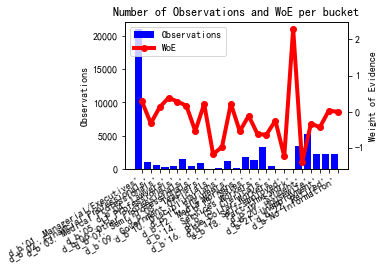

Residential_status


C:\Users\THINKPAD\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


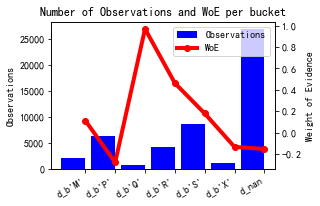

In [142]:
from woe import WoE
for col in Model_Base.columns[1:]:
    if Model_Base[col].dtype == 'O':
        if col.lower().startswith('cust'):
            continue
        else:
            woe = WoE(v_type='d')
            woe.fit(Model_Base[col],Model_Base['response'])
            print(col)
            fig = woe.plot([4,3])            
            plt.show(fig)

In [143]:
col_nominal = []
for col in Model_Base.columns[1:]:
    if Model_Base[col].dtype == 'O':
        if col.lower().startswith('cust'):
            continue
        else:
            col_nominal.append(col)
col_nominal

['Education_level',
 'Gender_code',
 'Internet_bank_user',
 'Marital_status',
 'Occupation',
 'Residential_status']

In [144]:
Model_Base_creatval = Model_Base
dict_nominal = {'Education_level':[b'M',b'U'],'Gender_code':[b'M'],'Internet_bank_user':[b'Y'],'Marital_status':[b'D',b'M'],
                'Occupation':[b'01. Managerial/Executives',b'03. Medical Professionals',b'04. Lawyers',
                              b'05. IT Professionals',b'06. Other Professionals',b'08. Teachers',
                             b'11. Engineers'],
                'Residential_status':[b'Q',b'R',b'M',b'S']}
for key,value in dict_nominal.items():
    new = 'l_' + key
    #print(key,value)
    Model_Base_creatval[new] = Model_Base_creatval[key].map(lambda x: 1 if x in value else 0)

In [145]:
#Rsdl_dummies = pd.get_dummies(Model_Base_creatval['Residential_status'],prefix = '1_Rsdl').drop(["1_Rsdl_b'P'","1_Rsdl_b'R'","1_Rsdl_b'X'"], axis = 1)

#Model_Base_creatval = Model_Base_creatval.join(Rsdl_dummies)

Model_Base_creatval.drop(['Education_level','Gender_code','Internet_bank_user','Marital_status',
                          'Occupation','Residential_status','customer_id'], axis = 1, inplace = True)

In [146]:
Model_Base_creatval.head()

,Customer_ID,Age,Cust_RELATIONSHIP,Cust_RELATIONSHIP_L3,Cust_RELATIONSHIP_L6,CUR_CNT,CUR_AMT,CUR_LCY_CNT,CUR_LCY_AMT,CUR_AMT_L3,...,txn_sav_Deposit_amt,txn_sav_Withdrawal_cnt,txn_sav_Withdrawal_amt,response,l_Education_level,l_Gender_code,l_Internet_bank_user,l_Marital_status,l_Occupation,l_Residential_status
0,b'000001',57.0,114479.76,1.055302e+05,1.001128e+05,1.0,548.07,1.0,548.07,664.883333,...,280.07,2.0,1397.19,0,0,0,1,0,0,1
1,b'000002',62.0,376719.01,3.906975e+05,3.987731e+05,1.0,2475.90,1.0,2475.90,6075.900000,...,5296.29,3.0,1376.98,0,0,1,0,1,0,0
2,b'000003',60.0,1993206.89,1.989272e+06,2.364182e+06,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,1,1,0,0,0
3,b'000004',45.0,596724.55,6.062310e+05,6.111875e+05,1.0,68.36,1.0,68.36,68.360000,...,2612.99,NaN,NaN,0,1,1,1,0,0,0
4,b'000005',58.0,1482123.80,1.408081e+06,1.398073e+06,NaN,NaN,NaN,NaN,NaN,...,175181.73,10.0,116873.63,0,1,1,0,1,1,0


## Q4(c)

In [147]:
col_nominal = []
for col in Model_Base_creatval.columns:
    if col.startswith('1_'):
        col_nominal.append(col)

col_num = []
for col in Model_Base_creatval.columns:
    if col.startswith('1_') or col == 'Customer_ID' or col == 'response':
        continue
    else:
        col_num.append(col)

col_expl = col_num + col_nominal

In [148]:
from scipy import stats
spearman_rho, spearman_pval = stats.spearmanr(Model_Base_creatval[col_num + ['response']])

C:\Users\THINKPAD\Anaconda3\lib\site-packages\scipy\stats\stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


- 题目要求是Hoeffding Correlation method度量非线性相关，此处我们使用kendall Correlation method度量非线性相关

In [149]:
#kendall_table = pd.DataFrame({'val': val, 'kendall_tau': kendall_tau, 'kendall_pval': kendall_pval})

spearman_table = pd.DataFrame({'val': col_num + ['response'], 'spearman_rho': spearman_rho[-1], 'spearman_pval': spearman_pval[-1]})

In [150]:
spearman_table[((spearman_table.spearman_rho > 0.03) | (spearman_table.spearman_rho < -0.03)) & 
               (spearman_table.spearman_pval < 0.05)]

,val,spearman_rho,spearman_pval
0,Age,0.058833,1.367014e-39
1,Cust_RELATIONSHIP,0.110842,1.961640e-136
2,Cust_RELATIONSHIP_L3,0.110680,4.871755e-136
3,Cust_RELATIONSHIP_L6,0.110227,6.182058e-135
30,SAV_LCY_CNT,-0.065270,2.422986e-48
36,SAV_AMT_pct,-0.030616,7.519377e-12
38,SAV_CNT_L6,-0.038038,1.763073e-17
49,SAV_LCY_CNT_L3,-0.068822,1.469420e-53
50,SAV_LCY_CNT_L6,-0.070166,1.322825e-55
100,txn_sav_Others_cnt,0.053384,6.866288e-33


In [151]:
numcol_sel = spearman_table[((spearman_table.spearman_rho > 0.03) | (spearman_table.spearman_rho < -0.03)) & 
               (spearman_table.spearman_pval < 0.05)].val
numcol_sel = list(numcol_sel)
numcol_sel.remove('response')

# Q5 Varible Transformation

#### 缺失值、异常值

In [152]:
def missing(arr):
    return arr.isnull().sum()/len(arr)
msg = pd.DataFrame(Model_Base_creatval[numcol_sel].agg(missing),columns = ['missing'])

def qntl(arr):
    return arr.quantile([0,0.25,0.5,0.75,0.9,0.95,0.99,1])
decile = Model_Base_creatval[numcol_sel].agg(qntl).T

In [153]:
pd.merge(decile, msg, left_index=True,right_index=True )

,0.0,0.25,0.5,0.75,0.9,0.95,0.99,1.0,missing
Age,18.000000,32.000000,40.000000,4.900000e+01,5.800000e+01,6.300000e+01,7.400000e+01,1.020000e+02,0.00010
Cust_RELATIONSHIP,0.970000,157104.082500,577645.375000,2.027191e+06,5.637055e+06,1.048801e+07,3.105979e+07,8.228034e+08,0.00004
Cust_RELATIONSHIP_L3,0.993333,155841.688333,576535.480000,2.039938e+06,5.597110e+06,1.038232e+07,3.094556e+07,8.515281e+08,0.00002
Cust_RELATIONSHIP_L6,0.783333,154703.626667,569289.815000,2.001868e+06,5.432543e+06,1.011686e+07,3.012738e+07,8.446143e+08,0.00002
SAV_LCY_CNT,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,5.000000e+00,0.28684
SAV_AMT_pct,-99.999999,-26.087532,-0.043972,1.978959e+01,1.380589e+02,4.355291e+02,8.242616e+03,6.911178e+09,0.27428
SAV_CNT_L6,1.000000,1.000000,1.000000,1.000000e+00,2.000000e+00,2.000000e+00,3.833333e+00,1.533333e+01,0.24608
SAV_LCY_CNT_L3,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,4.666667e+00,0.27784
SAV_LCY_CNT_L6,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,4.166667e+00,0.27090
txn_sav_Others_cnt,-1.000000,1.000000,2.000000,6.000000e+00,1.500000e+01,3.000000e+01,1.230000e+02,1.271700e+04,0.39396


In [154]:
numcol_sel

['Age',
 'Cust_RELATIONSHIP',
 'Cust_RELATIONSHIP_L3',
 'Cust_RELATIONSHIP_L6',
 'SAV_LCY_CNT',
 'SAV_AMT_pct',
 'SAV_CNT_L6',
 'SAV_LCY_CNT_L3',
 'SAV_LCY_CNT_L6',
 'txn_sav_Others_cnt',
 'txn_sav_Others_amt',
 'txn_sav_Deposit_cnt',
 'l_Education_level',
 'l_Gender_code',
 'l_Marital_status',
 'l_Occupation',
 'l_Residential_status']

-  利用scorecardpy 进行WoE

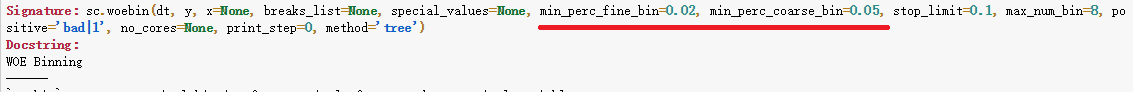

In [168]:
import scorecardpy as sc
import matplotlib.pyplot as plt
col_c= numcol_sel+['response'] 
breaks_list = {
  'l_Education_level': [0.5],
  'l_Gender_code': [0.5],
  'l_Marital_status': [0.5],
  'l_Occupation': [0.5],
  'l_Residential_status': [0.5]    
}
#进行分箱
bins = sc.woebin(Model_Base_creatval[col_c], y='response',method="chimerge",positive="1",breaks_list=breaks_list)

Binning on 50000 rows and 18 columns in 00:00:15


In [211]:
?sc.woebin

In [169]:
bins['Cust_RELATIONSHIP_L6']

,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,Cust_RELATIONSHIP_L6,missing,1,0.00002,0,1,1.000000,3.092306,0.001229,0.283493,missing,True
1,Cust_RELATIONSHIP_L6,"[-inf,200000.0)",14572,0.29144,14248,324,0.022234,-0.796683,0.130962,0.283493,200000.0,False
2,Cust_RELATIONSHIP_L6,"[200000.0,400000.0)",6752,0.13504,6526,226,0.033472,-0.376069,0.016161,0.283493,400000.0,False
3,Cust_RELATIONSHIP_L6,"[400000.0,1200000.0)",10586,0.21172,10114,472,0.044587,-0.077752,0.001236,0.283493,1200000.0,False
4,Cust_RELATIONSHIP_L6,"[1200000.0,2200000.0)",6521,0.13042,6132,389,0.059653,0.229248,0.007609,0.283493,2200000.0,False
5,Cust_RELATIONSHIP_L6,"[2200000.0,4800000.0)",5897,0.11794,5470,427,0.072410,0.436695,0.027480,0.283493,4800000.0,False
6,Cust_RELATIONSHIP_L6,"[4800000.0,inf)",5671,0.11342,5109,562,0.099101,0.779688,0.098815,0.283493,inf,False


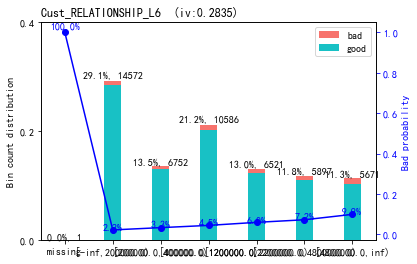

In [170]:
sc.woebin_plot(bins['Cust_RELATIONSHIP_L6'])
plt.show()

In [171]:
#%%计算粗分项的iv值
iv_info = []
for i in numcol_sel:
    var = i
    iv = bins[i]['total_iv'][0]
    iv_info.append([var,iv])
    
iv_info_df = pd.DataFrame(np.array(iv_info),columns=['fea_name','iv'])
iv_info_df = iv_info_df.sort_values(by='iv',axis=0,ascending=False)
iv_info_df

,fea_name,iv
6,SAV_CNT_L6,0.8380675008818979
5,SAV_AMT_pct,0.5870577000910012
8,SAV_LCY_CNT_L6,0.42497964900531204
7,SAV_LCY_CNT_L3,0.37196289177890357
4,SAV_LCY_CNT,0.3324153484365068
2,Cust_RELATIONSHIP_L3,0.2877923054735154
1,Cust_RELATIONSHIP,0.2858672411596811
3,Cust_RELATIONSHIP_L6,0.2834929732679349
11,txn_sav_Deposit_cnt,0.24286503405748866
10,txn_sav_Others_amt,0.22022346971396378


In [183]:
#选取IV值大于1的变量
var_sel= set(numcol_sel)-set(['l_Residential_status','l_Gender_code','l_Marital_status'])
#woe转换

for_model_woe_X = sc.woebin_ply(Model_Base_creatval[list(var_sel)], bins)
for_model_woe_XY = for_model_woe_X.join(Model_Base_creatval.response)
for_model_woe_XY.head()

,Age_woe,SAV_AMT_pct_woe,SAV_LCY_CNT_L3_woe,SAV_LCY_CNT_L6_woe,txn_sav_Deposit_cnt_woe,Cust_RELATIONSHIP_woe,l_Occupation_woe,SAV_LCY_CNT_woe,txn_sav_Others_amt_woe,txn_sav_Others_cnt_woe,Cust_RELATIONSHIP_L6_woe,l_Education_level_woe,Cust_RELATIONSHIP_L3_woe,SAV_CNT_L6_woe,response
0,0.274382,0.694686,0.268549,0.273039,0.434996,-0.799462,-0.399436,0.266545,0.176941,0.210339,-0.796683,-0.777167,-0.794144,0.789925,0
1,0.274382,-0.012987,0.268549,0.273039,0.255409,-0.389141,-0.399436,0.266545,0.348013,0.427860,-0.376069,-0.777167,-0.420350,0.184150,0
2,0.274382,-1.936881,-1.428133,-1.611555,-0.786908,0.307864,-0.399436,-1.281852,-0.707170,-0.707170,0.436695,-0.777167,0.200867,-2.962413,0
3,0.055921,0.694686,0.268549,0.273039,0.255409,-0.061023,-0.399436,0.266545,0.176941,0.210339,-0.077752,0.187564,-0.103742,0.789925,0
4,0.274382,0.077787,0.268549,0.273039,0.434996,0.307864,0.275447,0.266545,0.636067,0.427860,0.229248,0.187564,0.200867,0.184150,0


# Q6 Model fitting

## Q6a

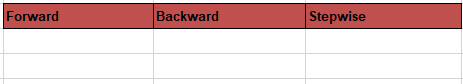

#### 划分训练集、测试集

In [184]:
from sklearn.cross_validation import train_test_split
X=for_model_woe_X
y=Model_Base_creatval.response

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)

print("Number transactions train dataset: ", len(X_train))
print("Number transactions test dataset: ", len(X_test))
print("Total number of transactions: ", len(X_train)+len(X_test))

Number transactions train dataset:  35000
Number transactions test dataset:  15000
Total number of transactions:  50000


C:\Users\THINKPAD\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### 前向选择

In [192]:
import logistic_model_select as lms
lms.forward_select(X_train.join(y_train), "response")

aic is 12530.358789236,continuing!
aic is 12173.57078387564,continuing!
aic is 12042.734677737293,continuing!
aic is 11970.465539765499,continuing!
aic is 11945.1181320381,continuing!
aic is 11928.953212592809,continuing!
aic is 11925.3971207337,continuing!
aic is 11924.922513757527,continuing!
aic is 11924.840843170587,continuing!
forward selection over!
final formula is response ~ SAV_CNT_L6_woe + Cust_RELATIONSHIP_L3_woe + l_Education_level_woe + Age_woe + l_Occupation_woe + SAV_AMT_pct_woe + txn_sav_Others_cnt_woe + Cust_RELATIONSHIP_woe + txn_sav_Others_amt_woe 


In [197]:
var_forward_select=['SAV_CNT_L6_woe','Cust_RELATIONSHIP_L3_woe','l_Education_level_woe','Age_woe','l_Occupation_woe','SAV_AMT_pct_woe','txn_sav_Others_cnt_woe','Cust_RELATIONSHIP_woe','txn_sav_Others_amt_woe']
import statsmodels.api as sm
lr = sm.Logit( y_train,X_train[var_forward_select]).fit()
lr.summary() 

Optimization terminated successfully.
         Current function value: 0.568875
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               response   No. Observations:                35000
Model:                          Logit   Df Residuals:                    34991
Method:                           MLE   Df Model:                            8
Date:                Fri, 22 Mar 2019   Pseudo R-squ.:                  -1.970
Time:                        06:50:26   Log-Likelihood:                -19911.
converged:                       True   LL-Null:                       -6704.5
                                        LLR p-value:                     1.000
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
SAV_CNT_L6_woe               0.7917      0.022     36.686      0.000       0.749       0.834
Cust_RELATIONSHIP_L3_woe     0.5021      0.098      5.104      0.000       0.309       0.695
l_Education_level_woe        0.6660      0.030     22.073      0.000       0.607       0.725
Age_woe                      0.4268      0.028     15.343      0.000       0.372       0.481
l_Occupation_woe             0.3950      0.038     10.450      0.000       0.321       0.469
SAV_AMT_pct_woe             -0.0430      0.027     -1.597      0.110      -0.096       0.010
txn_sav_Others_cnt_woe      -0.7212      0.119     -6.043      0.000      -0.955      -0.487
Cust_RELATIONSHIP_woe        0.2409      0.099      2.445      0.014       0.048       0.434
txn_sav_Others_amt_woe       0.1409      0.117      1.200      0.230      -0.089       0.371
============================================================================================
"""

- 符号不一致，需要剔除P值不显著和共线性较强的变量（VIF大于6）

In [198]:
def vif(df, col_i):
    from statsmodels.formula.api import ols
    
    cols = list(df.columns)
    cols.remove(col_i)
    cols_noti = cols
    formula = col_i + '~' + '+'.join(cols_noti)
    r2 = ols(formula, df).fit().rsquared
    return 1. / (1. - r2)

exog = X_train[var_forward_select]

for i in exog.columns:
    print(i, '\t', vif(df=exog, col_i=i))

SAV_CNT_L6_woe 	 6.443153956941954
Cust_RELATIONSHIP_L3_woe 	 19.839151841924394
l_Education_level_woe 	 1.073504198209164
Age_woe 	 1.1724101034357668
l_Occupation_woe 	 1.1419733059196024
SAV_AMT_pct_woe 	 5.644428309161716
txn_sav_Others_cnt_woe 	 27.424983412084583
Cust_RELATIONSHIP_woe 	 19.794261158283714
txn_sav_Others_amt_woe 	 26.93722857144804


- 根据IV值和VIF，在VIF较高的变量中，保留IV值高的

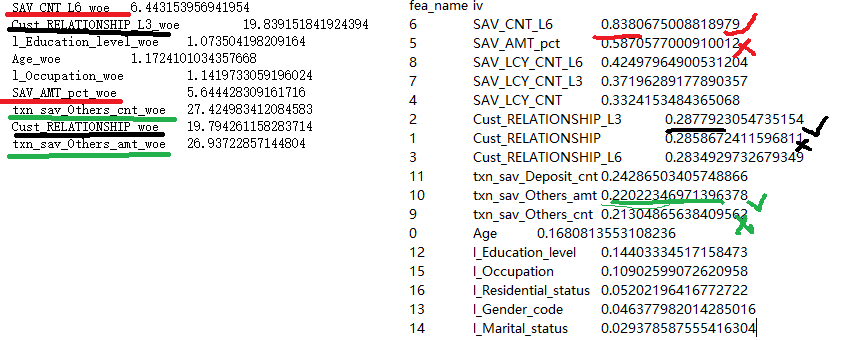

In [199]:
#删除SAV_AMT_pct_woe，Cust_RELATIONSHIP_woe，txn_sav_Others_cnt_woe,
var_forward_select=['SAV_CNT_L6_woe','l_Education_level_woe','Age_woe','l_Occupation_woe','Cust_RELATIONSHIP_L3_woe','txn_sav_Others_amt_woe']
exog = X_train[var_forward_select]

for i in exog.columns:
    print(i, '\t', vif(df=exog, col_i=i))

SAV_CNT_L6_woe 	 1.9755302521058098
l_Education_level_woe 	 1.0724008772379086
Age_woe 	 1.1706197642348362
l_Occupation_woe 	 1.141565611895663
Cust_RELATIONSHIP_L3_woe 	 1.1672871783358165
txn_sav_Others_amt_woe 	 2.020492385089747


In [200]:
lr = sm.Logit( y_train,X_train[var_forward_select]).fit()
lr.summary() 

Optimization terminated successfully.
         Current function value: 0.569522
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               response   No. Observations:                35000
Model:                          Logit   Df Residuals:                    34994
Method:                           MLE   Df Model:                            5
Date:                Fri, 22 Mar 2019   Pseudo R-squ.:                  -1.973
Time:                        06:50:48   Log-Likelihood:                -19933.
converged:                       True   LL-Null:                       -6704.5
                                        LLR p-value:                     1.000
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
SAV_CNT_L6_woe               0.7549      0.013     56.352      0.000       0.729       0.781
l_Education_level_woe        0.6720      0.030     22.304      0.000       0.613       0.731
Age_woe                      0.4277      0.028     15.420      0.000       0.373       0.482
l_Occupation_woe             0.3997      0.038     10.583      0.000       0.326       0.474
Cust_RELATIONSHIP_L3_woe     0.7353      0.024     30.475      0.000       0.688       0.783
txn_sav_Others_amt_woe      -0.5415      0.032    -16.753      0.000      -0.605      -0.478
============================================================================================
"""

#### 后向选择

#### 逐步回归

####  数据不平衡，采用过采样平衡
- 此部分数据不平衡处理内容不是必须的

## Q6b

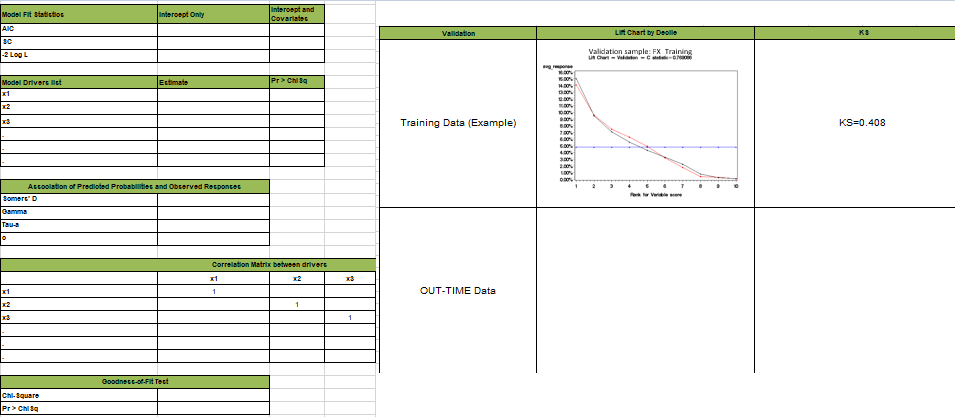

#### 模型拟合与校验

In [204]:
from sklearn.metrics import accuracy_score

y_pred = lr.predict(X_test[var_forward_select]) >0.5
print("Test set accuracy score: {:.5f}".format(accuracy_score(y_pred, y_test)))

Test set accuracy score: 0.64633


In [209]:
# 混淆矩阵
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Recall metric in the testing dataset:  0.7421555252387448


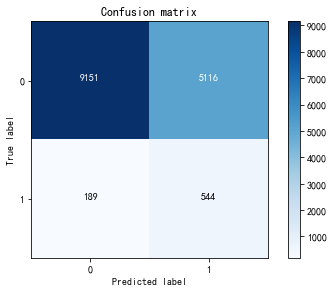

In [210]:
from sklearn.metrics import confusion_matrix
import itertools

cnf_matrix = confusion_matrix(y_test,y_pred)
print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

#### lift曲线

In [206]:
y_proba = lr.predict(X_test[var_forward_select])

lift_tab = pd.DataFrame({"prob":y_proba, "label":y_test}).sort_values(by = 'prob', ascending = False)

for n in range(10):
    a = lift_tab[n*len(y_proba)//10: (n + 1)*len(y_proba)//10].groupby('label').count().T
    a.index = [str(n + 1) + 'Decile']
    if n == 0:
        b = a
    else:
        b = pd.concat([b,a])
b['RR'] = b[1].map(lambda x: x/b[1].sum())   

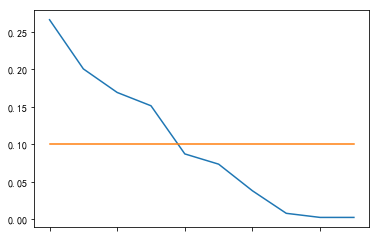

In [207]:
b['RR'].plot()
pd.Series([0.1 for x in range(10)], index = [str(x) + 'Decile' for x in range(1,11)]).plot()

#### ROC

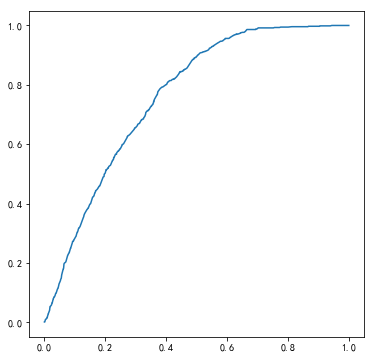

In [208]:
import sklearn.metrics as metrics

fpr_test, tpr_test, th_test = metrics.roc_curve(y_test, y_proba)
plt.figure(figsize = [6,6])
plt.plot(fpr_test, tpr_test)
plt.show()


## Q6C

## 思考题：
- spearman，Kendalltau分别针对线性、非线性变量，在使用时候，如何知道哪个变量是线性非线性？  

- 在前向选择、后向选择和逐步回归筛选变量时候，可否将分类哑变量入模？还是变量筛选只能针对连续变量？  